In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import os
import sys
import fiona
from scipy.spatial import cKDTree
import numpy as np
from shapely import wkt
import time
from rtree import index

sys.path.append(os.path.realpath('..'))

Line data

In [3]:
shp_file = r"../intermediate_data/lion_gdf2012/lion_gdf2012.shp"
lion_gdf = gpd.read_file(shp_file)
lion_gdf.crs = {'init': 'epsg:4326'}

Point data from the Sidewalk Café Licenses and Applications

In [4]:
fp = r"https://data.cityofnewyork.us/api/views/qcdj-rwhu/rows.csv?accessType=DOWNLOAD"
sidewalk_df = pd.read_csv(fp)

In [5]:
sidewalk_df['geometry'] =  list(zip(sidewalk_df['LONGITUDE'], sidewalk_df['LATITUDE']))

In [6]:
sidewalk_df['geometry'] = sidewalk_df['geometry'].apply(Point)

In [7]:
sidewalk_gdf = gpd.GeoDataFrame(sidewalk_df, geometry='geometry',crs = {'init': 'epsg:4326'})

In [9]:
sidewalk_gdf.head()

,LICENSE_NBR,LIC_STATUS,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,CITY,STATE,ZIP,SWC_TYPE,...,HEARING_DD,HEARING_PUBLIC,HEARING_PUBLIC_DD,CC,CC_DD,MOO,MOO_DD,ISSUANCE,ISSUANCE_DD,geometry
0,2042126-DCA,Active,THE ELEMENT RESTAURANT GROUP INC,181 CABRINI,854,W 181ST ST,NEW YORK,NY,10033,Unenclosed,...,12/13/2018,NaN,NaN,Review Period Expired,01/03/2019,Pending Review,NaN,Pending Review,NaN,POINT (-73.93992100497887 40.85108121215804)
1,1139678-DCA,Active,"THE ORIGINAL VINCENT'S, ESTABLISHED 1904 INC.",NaN,119,MOTT ST,NEW YORK,NY,10013,Unenclosed,...,01/19/2018,NaN,NaN,Review Period Expired,01/19/2018,Waived,01/19/2018,Issued,01/19/2018,POINT (-73.99731247308198 40.71786474110945)
2,2038120-DCA,Active,LUKE'S LOUNGE INC,NaN,1808,HONE AVE,BRONX,NY,10461,Unenclosed,...,02/28/2019,NaN,NaN,Review Period Expired,03/21/2019,Approved,05/02/2019,Issued,05/02/2019,POINT (-73.85497001294844 40.84922986597552)
3,1193339-DCA,Active,"EISEN & SON, INC.",LASAGNA RESTAURANT,196,8TH AVE,NEW YORK,NY,10011,Unenclosed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Issued,09/18/2017,POINT (-73.99979069006966 40.74322630997722)
4,2028248-DCA,Active,BILTMORE GARAGE RESTAURANT ASSOCIATES LLC,MEL'S BURGER BAR,1450,2ND AVE,NEW YORK,NY,10021,Unenclosed,...,12/14/2017,NaN,NaN,Approved,12/14/2017,Approved,12/14/2017,Issued,12/14/2017,POINT (-73.95649231137126 40.77099765829954)


## Snap all locations to line
- Wanted to run the algorithm on the entire dataset
- It was too memory intensive
- Split the data into borough level chunks to work

Find the nearest line to student nodee

In [14]:
def snap_to_line(point, line_gdf, spatial_index):
    nearest_line_index = list(spatial_index.nearest(point.bounds))
    line = line_gdf['geometry'].iloc[nearest_line_index[0]]
    point_snapped = line.interpolate(line.project(point))
    return point_snapped,nearest_line_index[0]

Create spatial index

In [11]:
spatial_index = lion_gdf.sindex

In [15]:
sidewalk_gdf[['nearest_point_on_line','on_line']] = sidewalk_gdf.apply(lambda row: snap_to_line(row['geometry'],lion_gdf, spatial_index), axis=1, result_type = 'expand')

In [16]:
sidewalk_gdf.head()

,LICENSE_NBR,LIC_STATUS,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,CITY,STATE,ZIP,SWC_TYPE,...,HEARING_PUBLIC_DD,CC,CC_DD,MOO,MOO_DD,ISSUANCE,ISSUANCE_DD,geometry,nearest_point_on_line,on_line
0,2042126-DCA,Active,THE ELEMENT RESTAURANT GROUP INC,181 CABRINI,854,W 181ST ST,NEW YORK,NY,10033,Unenclosed,...,NaN,Review Period Expired,01/03/2019,Pending Review,NaN,Pending Review,NaN,POINT (-73.93992100497887 40.85108121215804),POINT (-73.93989685705797 40.85132131512788),65509
1,1139678-DCA,Active,"THE ORIGINAL VINCENT'S, ESTABLISHED 1904 INC.",NaN,119,MOTT ST,NEW YORK,NY,10013,Unenclosed,...,NaN,Review Period Expired,01/19/2018,Waived,01/19/2018,Issued,01/19/2018,POINT (-73.99731247308198 40.71786474110945),POINT (-73.99716714163807 40.71777462231699),67875
2,2038120-DCA,Active,LUKE'S LOUNGE INC,NaN,1808,HONE AVE,BRONX,NY,10461,Unenclosed,...,NaN,Review Period Expired,03/21/2019,Approved,05/02/2019,Issued,05/02/2019,POINT (-73.85497001294844 40.84922986597552),POINT (-73.85497716139835 40.84922428758369),13383
3,1193339-DCA,Active,"EISEN & SON, INC.",LASAGNA RESTAURANT,196,8TH AVE,NEW YORK,NY,10011,Unenclosed,...,NaN,NaN,NaN,NaN,NaN,Issued,09/18/2017,POINT (-73.99979069006966 40.74322630997722),POINT (-73.99972826980175 40.74337448032719),60047
4,2028248-DCA,Active,BILTMORE GARAGE RESTAURANT ASSOCIATES LLC,MEL'S BURGER BAR,1450,2ND AVE,NEW YORK,NY,10021,Unenclosed,...,NaN,Approved,12/14/2017,Approved,12/14/2017,Issued,12/14/2017,POINT (-73.95649231137126 40.77099765829954),POINT (-73.95666905608053 40.77112649759413),57296


Plot the visualization

In [27]:
line_index = lion_gdf.iloc[sidewalk_gdf['on_line'].iloc[0]]
point = sidewalk_gdf['geometry'].iloc[0]
point_on_line = sidewalk_gdf['nearest_point_on_line'].iloc[0]

In [33]:
lion_gdf.head()

,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,distance,geometry
0,EAST 168 STREET,None,0,U,None,B,None,T,DOT,None,...,596,716,599,699,596,716,2251001000000,437.282030,0.001442,LINESTRING (-73.90346685864002 40.830353796457...
1,WEST 192 STREET,None,0,U,None,B,None,A,DOT,None,...,63,99,58,98,63,99,2798401000000,279.360551,0.000954,LINESTRING (-73.90120067721222 40.866613078165...
2,UNION AVENUE,None,0,U,None,B,None,W,DOT,None,...,1016,1084,1017,1079,1016,1084,2728001000000,618.327104,0.001752,LINESTRING (-73.90117669126199 40.824388909173...
3,DELAFIELD AVENUE,None,0,U,None,B,None,T,DOT,None,...,4600,4664,4601,4645,4600,4664,2187601000000,670.281005,0.001840,LINESTRING (-73.9069566348925 40.8936079352015...
4,WEST 252 STREET,None,0,U,None,B,None,T,DCP,None,...,None,None,0,0,0,0,2814401000000,16.897558,0.000059,LINESTRING (-73.90706510086257 40.899274141493...


In [50]:
i = lion_gdf['SegmentID'].iloc[sidewalk_gdf['on_line'].iloc[0]]
print(i)

0070983


In [53]:
sidewalk_gdf.head()

,LICENSE_NBR,LIC_STATUS,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,CITY,STATE,ZIP,SWC_TYPE,...,HEARING_PUBLIC_DD,CC,CC_DD,MOO,MOO_DD,ISSUANCE,ISSUANCE_DD,geometry,nearest_point_on_line,on_line
0,2042126-DCA,Active,THE ELEMENT RESTAURANT GROUP INC,181 CABRINI,854,W 181ST ST,NEW YORK,NY,10033,Unenclosed,...,NaN,Review Period Expired,01/03/2019,Pending Review,NaN,Pending Review,NaN,POINT (-73.93992100497887 40.85108121215804),POINT (-73.93989685705797 40.85132131512788),65509
1,1139678-DCA,Active,"THE ORIGINAL VINCENT'S, ESTABLISHED 1904 INC.",NaN,119,MOTT ST,NEW YORK,NY,10013,Unenclosed,...,NaN,Review Period Expired,01/19/2018,Waived,01/19/2018,Issued,01/19/2018,POINT (-73.99731247308198 40.71786474110945),POINT (-73.99716714163807 40.71777462231699),67875
2,2038120-DCA,Active,LUKE'S LOUNGE INC,NaN,1808,HONE AVE,BRONX,NY,10461,Unenclosed,...,NaN,Review Period Expired,03/21/2019,Approved,05/02/2019,Issued,05/02/2019,POINT (-73.85497001294844 40.84922986597552),POINT (-73.85497716139835 40.84922428758369),13383
3,1193339-DCA,Active,"EISEN & SON, INC.",LASAGNA RESTAURANT,196,8TH AVE,NEW YORK,NY,10011,Unenclosed,...,NaN,NaN,NaN,NaN,NaN,Issued,09/18/2017,POINT (-73.99979069006966 40.74322630997722),POINT (-73.99972826980175 40.74337448032719),60047
4,2028248-DCA,Active,BILTMORE GARAGE RESTAURANT ASSOCIATES LLC,MEL'S BURGER BAR,1450,2ND AVE,NEW YORK,NY,10021,Unenclosed,...,NaN,Approved,12/14/2017,Approved,12/14/2017,Issued,12/14/2017,POINT (-73.95649231137126 40.77099765829954),POINT (-73.95666905608053 40.77112649759413),57296


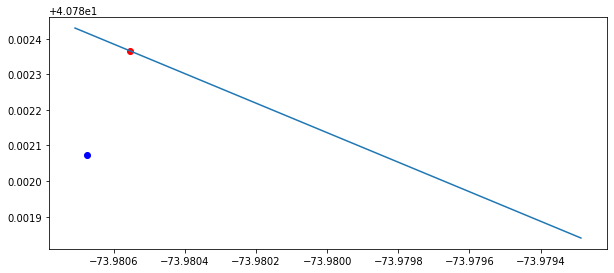

In [59]:
i = 425
f, ax = plt.subplots(1, figsize=(10, 10))

lion_gdf.loc[lion_gdf['SegmentID'] == lion_gdf['SegmentID'].iloc[sidewalk_gdf['on_line'].iloc[i]]].plot(ax=ax)
sidewalk_gdf = sidewalk_gdf.set_geometry('geometry')
# Original point
sidewalk_gdf.loc[sidewalk_gdf.index == i].plot(ax=ax, color = 'blue')
sidewalk_gdf = sidewalk_gdf.set_geometry('nearest_point_on_line')
# Snapped point
sidewalk_gdf.loc[sidewalk_gdf.index == i].plot(ax=ax, color = 'red')

plt.show();